# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
!python3 -m spacy download en_core_web_sm 

     |████████████████████████████████| 13.9 MB 1.4 MB/s eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
# Блок импорта
import pandas as pd
import re
import math
import numpy as np
import matplotlib.pyplot as plt
from pymystem3 import Mystem
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import spacy
import en_core_web_sm

from spacy.lookups import Lookups

import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
from nltk.tag import pos_tag

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.utils import shuffle

from tqdm import tqdm
import torch
from transformers import BertTokenizer
from transformers import BertModel
from transformers import BertForMaskedLM
import transformers
from tqdm import notebook

from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier

*Посмотрим на данные*

In [3]:
df=pd.read_csv('/datasets/toxic_comments.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [5]:
# Получим список стоп-слов
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
df.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


*Видим, что в нашем датасете около 150 000+ строк. Посмотрим на распределение целевого признака.*

***Первичная обработка данных***

(-1.25, 1.25, -1.25, 1.25)

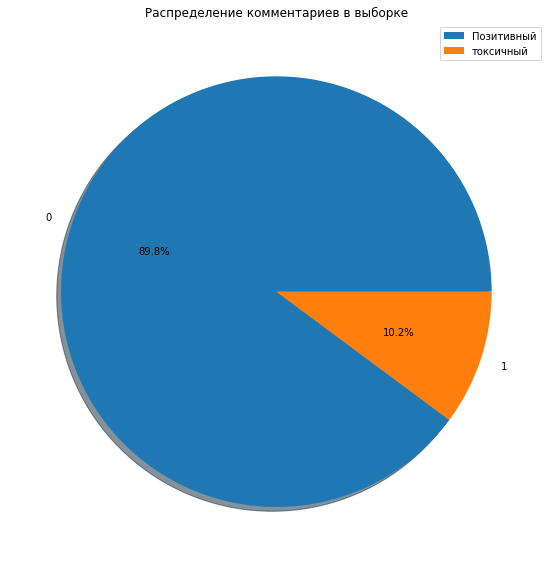

In [7]:
df.toxic.value_counts().plot(kind='pie', autopct='%1.1f%%', shadow=True, figsize=(10,8))
plt.legend(['Позитивный','токсичный'])
plt.title('Распределение комментариев в выборке')
plt.tight_layout()
plt.axis('off')

**Видим, что у нас дисбаланс выборки. Позитивных комментариев больше, чем токсичных. Так же помним, что комментарии были выгружены с какими-то спец.символами и числами. Очистим их с помощью регулярных выражений и лемматизируем**

In [8]:
def clean_symbols(text):
    text = re.sub(r"[^a-zA-Z ]+", " ", text)
    return text.strip().lower()

In [9]:
df['text'] = df['text'].apply(clean_symbols)

In [10]:
#скачаем необходимые пакеты
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
wnl = WordNetLemmatizer()
tknzr = TweetTokenizer()
def lemmatize(text, m=wnl):
    word_list = tknzr.tokenize(text)
    tagged_words = nltk.pos_tag(word_list)
    lemmatized_words = []
    for word, tag in tagged_words:
        if tag.startswith('N'):
            lemmatized_words.append(m.lemmatize(word, pos='n'))
        elif tag.startswith('V'):
            lemmatized_words.append(m.lemmatize(word, pos='v'))
        elif tag.startswith('R'):
            lemmatized_words.append(m.lemmatize(word, pos='r'))
        elif tag.startswith('J'):
            lemmatized_words.append(m.lemmatize(word, pos='a'))
        else:
            lemmatized_words.append(word)
            
    return ' '.join(lemmatized_words)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [11]:
df['text'] = df['text'].apply(lemmatize)

## Обучение

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['toxic'],
                                                    test_size=0.2, random_state=42, stratify=df.toxic)

In [13]:
train_corpus = X_train
corpus_test = X_test

In [14]:
tfv = TfidfVectorizer(stop_words=stop_words, ngram_range=(1,2))

In [15]:
X_vector_train = tfv.fit_transform(train_corpus)
X_vector_test = tfv.transform(corpus_test)

In [16]:
model_lr =LogisticRegression(random_state=42)
model_sgd = SGDClassifier(random_state=42)

params_lr = {
          'class_weight':['balanced'],
          'C':[3],
          'max_iter':[500]}        

params_sgd = {
        'class_weight':['balanced', None],
        'max_iter':[500,1000],
        'loss':['log','squared_hinge'],
        'shuffle':[True],
        'penalty':['l1'],
        'n_iter_no_change':[20,30]}

In [17]:
grid_lr = GridSearchCV(model_lr, param_grid=params_lr, scoring='f1',verbose=3, cv=5, n_jobs=-1)

In [ ]:
grid_lr.fit(X_vector_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END .......C=3, class_weight=balanced, max_iter=500; total time= 2.7min
[CV 2/5] END .......C=3, class_weight=balanced, max_iter=500; total time= 2.6min


In [ ]:
grid_lr.best_score_

In [ ]:
grid_lr.best_params_

In [ ]:
grid_sgd = GridSearchCV(model_sgd, param_grid=params_sgd, scoring='f1',verbose=3, cv=5, n_jobs=-1)

In [ ]:
grid_sgd.fit(X_vector_train, y_train)

In [ ]:
grid_sgd.best_score_

In [ ]:
grid_sgd.best_params_

**Итак, видим, что наилучшие показатели у логистической регрессии. Проверим на тесте.**

In [ ]:
pred = grid_lr.predict(X_vector_test)

In [ ]:
f1_score(y_test, pred)

In [ ]:
print(classification_report(pred, y_test))

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test, pred, normalize='true'),annot=True,fmt='.0%',cmap="summer")
plt.title('Матрица ошибок', y=1.05, size=15)

***Видим, что логистическая регрессия лучше справляется с задачей, хоть и время обучения дольше. Процент False Positive и False Negative различается, но удовлетворяет требования***

## Выводы

**Итак, можно сделать вывод, что исходя из данных лучше всего с предсказанием токсичных комментариев справиласть модель логистической регрессии. Что нам показывает как F1 оценка, так и матрица ошибок. Цель достигнута, модель обучена.**

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны